In [1]:
import geopandas as gpd
from shapely.geometry import Polygon
# Get barcode coordinates
#first_barcode_pxl_row, first_barcode_pxl_col, last_barcode_pxl_row, last_barcode_pxl_col = get_barcode_coordinates(df, one_micron)
geojson_file = '../data/processed/dataframe_ground_truth.geojson'

# Read GeoJSON file into a GeoDataFrame
gdf = gpd.read_file(geojson_file)

geometry = gdf[gdf['path_class'] == 'roi_cropped']['geometry'].iloc[0]

# Access exterior coordinates of the polygon
coordinates = geometry.exterior.coords.xy

# Assign coordinates to variables
first_barcode_pxl_row = int(min((coordinates[1])))  # Y-coordinate of the first point
first_barcode_pxl_col = int(min(coordinates[0]))# X-coordinate of the first point
last_barcode_pxl_row = int(max(coordinates[1]))  # Y-coordinate of the last point
last_barcode_pxl_col = int(max(coordinates[0]))  # X-coordinate of the last point

print(first_barcode_pxl_row, first_barcode_pxl_col,last_barcode_pxl_row,last_barcode_pxl_col)


37928 30713 41044 33865


In [55]:
import sys
sys.path.append('../utils')
import os

# Importing importlib for module reloading
import importlib
import image_cropp_utils

# Reloading the module
importlib.reload(image_cropp_utils)

from image_cropp_utils import read_image, crop_image, save_image_as_btf

# Read the image
dir_base = '../data/raw/p5/'
filename = 'Visium_HD_Human_Colon_Cancer_P5_tissue_image.btf'
img = read_image(dir_base + filename)

# Crop the image using the calculated coordinates
cropped_img = crop_image(img, first_barcode_pxl_row, first_barcode_pxl_col, last_barcode_pxl_row, last_barcode_pxl_col)

print(cropped_img.shape)

output_filename = 'p5_cropped_image_overlap_comparison.btf'
output_dir = '../data/processed'
output_path = os.path.join(output_dir, output_filename)
save_image_as_btf(cropped_img, output_path)

(3116, 3152, 3)
Cropped image saved as ../data/processed/p5_cropped_image_overlap_comparison.btf


In [56]:
import sys
sys.path.append('../utils')

# Importing importlib for module reloading
import importlib
import image_segmentation, geodataframe_creation
import matplotlib.pyplot as plt

# Reloading the module
importlib.reload(image_segmentation)

from skimage.io import imread
from image_segmentation import segment_image
from geodataframe_creation import create_geodataframe
from shapely.geometry import Polygon, box

# Assuming you have loaded 'cropped_img' using imread or some other method
#cropped_img = read your btf from previous step

# Perform image segmentation
polys = segment_image(cropped_img)

# Create GeoDataFrame from segmented polygons
gdf = create_geodataframe(polys)

# Adjusting the coordinates in the filtered GeoDataFrame using .loc to avoid SettingWithCopyWarning
def adjust_polygon(polygon, x_offset, y_offset):
    new_coords = [(float(x + x_offset), float(y +
                                               y_offset)) for x, y in polygon.exterior.coords]
    return Polygon(new_coords)
gdf.loc[:, 'geometry'] = gdf['geometry'].apply(lambda poly: adjust_polygon(poly, first_barcode_pxl_col, first_barcode_pxl_row))

geojson_file = '../data/processed/dataframe_ground_truth.geojson'
gdf_file = gpd.read_file(geojson_file)
geometry = gdf_file[gdf_file['path_class'] == 'new_roi']['geometry'].iloc[0]
gdf_filtered = gdf[gdf['geometry'].apply(lambda poly: poly.intersects(geometry))]
gdf_filtered.to_file('../data/processed/dataframe_stardist_overlap_comparison.geojson', driver='GeoJSON')

# Now 'gdf' contains the GeoDataFrame with polygons and IDs
print(gdf_filtered.head())


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
effective: block_size=(1008, 1008, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 25/25 [02:25<00:00,  5.84s/it]


                                               geometry       id
1590  POLYGON ((32962.222 38480.000, 32961.906 38482...  ID_1591
1591  POLYGON ((33056.947 38598.000, 33056.915 38599...  ID_1592
1594  POLYGON ((32879.516 38500.000, 32878.213 38503...  ID_1595
1595  POLYGON ((32941.069 38336.000, 32941.535 38337...  ID_1596
1596  POLYGON ((32960.061 38414.000, 32960.278 38415...  ID_1597


In [57]:
import geopandas as gpd
from shapely.geometry import Polygon, box

# Load the GeoDataFrame
gdf = gpd.read_file('../data/processed/dataframe_ground_truth.geojson')
gdf.crs = None

# Create a bounding box Polygon using the coordinates
bounding_box = box(first_barcode_pxl_col, first_barcode_pxl_row, last_barcode_pxl_col, last_barcode_pxl_row)

# Function to adjust polygon coordinates
def adjust_polygon(polygon, x_offset, y_offset):
    new_coords = [(float(x - x_offset), float(y - y_offset)) for x, y in polygon.exterior.coords]
    return Polygon(new_coords)

# Filter the GeoDataFrame where path_class is null
gdf_filtered = gdf[gdf['path_class'].isnull()].copy()

# Remove polygons outside the bounding box
gdf_filtered = gdf_filtered[gdf_filtered['geometry'].apply(lambda poly: poly.intersects(bounding_box))]

# Adjusting the coordinates in the filtered GeoDataFrame using .loc to avoid SettingWithCopyWarning
gdf_filtered.loc[:, 'geometry'] = gdf_filtered['geometry'].apply(lambda poly: adjust_polygon(poly, first_barcode_pxl_col, first_barcode_pxl_row))

# Save the updated GeoDataFrame back to a new GeoJSON file
gdf_filtered.to_file('../data/processed/updated_dataframe_ground_truth_overlap_comparison_intersect.geojson', driver='GeoJSON')

# Display the updated geometries
print(gdf_filtered['geometry'])


0       POLYGON ((782.000 9.000, 780.000 10.000, 779.0...
1       POLYGON ((710.000 8.000, 708.000 9.000, 707.00...
2       POLYGON ((8.000 2243.000, 7.000 2244.000, 6.00...
3       POLYGON ((22.000 2276.000, 21.000 2277.000, 19...
4       POLYGON ((-17.000 2266.000, -18.000 2267.000, ...
                              ...                        
1537    POLYGON ((1199.000 1825.000, 1198.000 1826.000...
1555    POLYGON ((1207.000 2227.000, 1205.000 2228.000...
1557    POLYGON ((1199.000 2176.000, 1197.000 2177.000...
1562    POLYGON ((723.000 -12.000, 721.000 -11.000, 71...
1579    POLYGON ((795.000 -29.000, 794.000 -28.000, 79...
Name: geometry, Length: 962, dtype: geometry


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


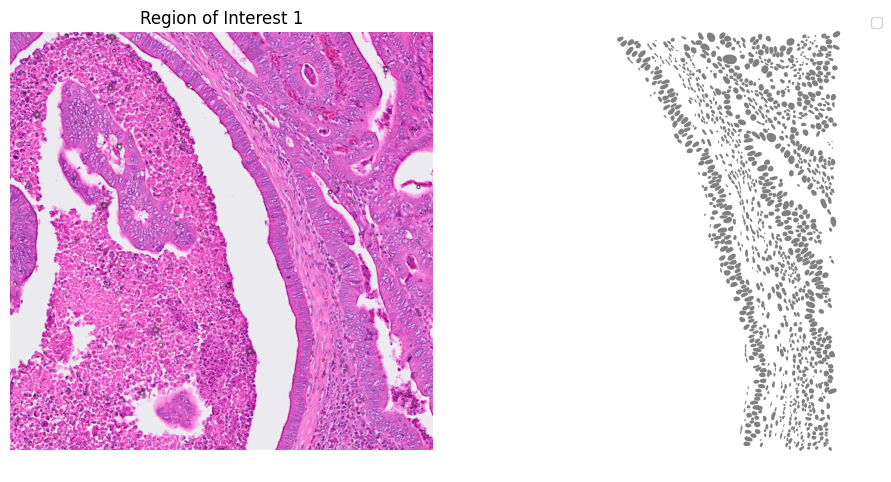

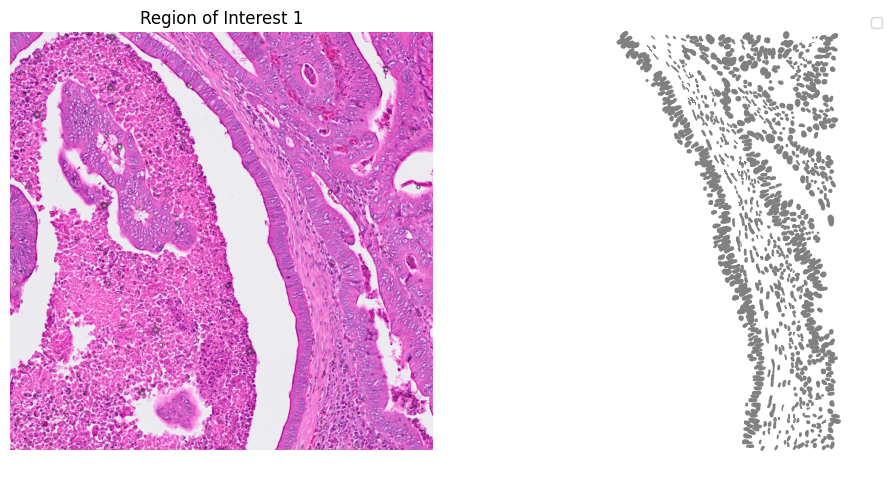

In [61]:
import importlib
import image_plot_utils

# Reloading the module
importlib.reload(image_plot_utils)

from skimage.io import imread
from image_plot_utils import plot_mask_and_save_image
from matplotlib.colors import ListedColormap

cmap=ListedColormap(['grey'])
gdf = gpd.read_file('../data/processed/dataframe_stardist_overlap_comparison.geojson')
gdf.crs = None
plot_mask_and_save_image(title="Region of Interest 1",
                         gdf=gdf,
                         cmap=cmap,
                         img=cropped_img,
                         output_name="../data/processed/p5_image_mask_stardist.ROI1.tif")


file_path = '../data/processed/updated_dataframe_ground_truth_overlap_comparison_intersect.geojson'
gdf3 = gpd.read_file(file_path)
gdf3.crs = gdf.crs

plot_mask_and_save_image(title="Region of Interest 1",
                         gdf=gdf_filtered,
                         cmap=cmap,
                         img=cropped_img,
                         output_name="../data/processed/p5_image_mask_Chang.ROI1.tif")


interactiveshell.py (3466): The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


           id                                           geometry  index_right  \
2     ID_1595  POLYGON ((731.516 186.000, 730.213 189.026, 72...          131   
26    ID_1637  POLYGON ((772.219 172.000, 771.805 174.547, 77...          131   
29    ID_1643  POLYGON ((762.749 198.000, 759.436 201.667, 75...          131   
140   ID_1885  POLYGON ((744.733 166.000, 744.932 167.976, 74...          131   
2     ID_1595  POLYGON ((731.516 186.000, 730.213 189.026, 72...          130   
...       ...                                                ...          ...   
1210  ID_6978  POLYGON ((1166.423 2294.000, 1168.088 2297.399...           68   
1217  ID_7036  POLYGON ((1147.975 2308.000, 1147.314 2312.041...           68   
1211  ID_6990  POLYGON ((1087.250 2278.000, 1087.247 2278.845...          922   
1212  ID_6998  POLYGON ((1077.767 2168.000, 1077.044 2170.396...          927   
1219  ID_7051  POLYGON ((1089.573 2148.000, 1090.303 2151.840...          927   

      path_class  
2       

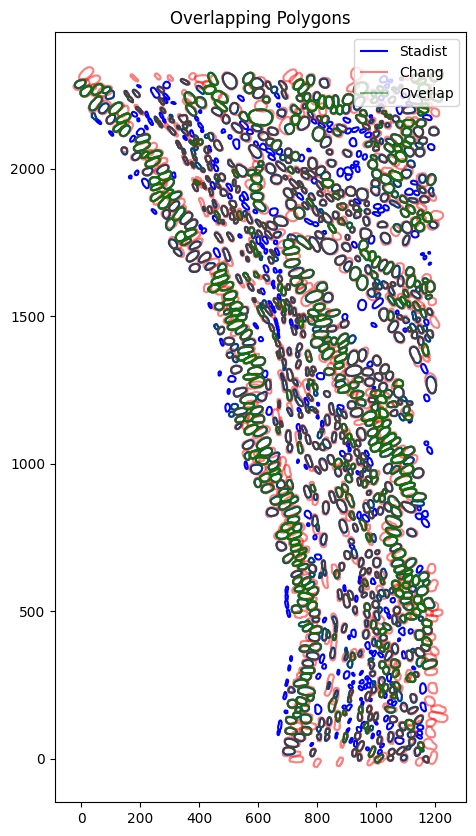

In [94]:
import geopandas as gpd
import matplotlib.pyplot as plt

# File paths to the GeoJSON files
file_path1 = '../data/processed/dataframe_stardist_overlap_comparison.geojson'
file_path2 = '../data/processed/updated_dataframe_ground_truth_overlap_comparison_intersect.geojson'

# Read the GeoJSON files into GeoDataFrames
gdf1 = gpd.read_file(file_path1)
gdf2 = gpd.read_file(file_path2)


gdf1.crs = None
def adjust_polygon(polygon, x_offset, y_offset):
    new_coords = [(float(x - x_offset), float(y - y_offset)) for x, y in polygon.exterior.coords]
    return Polygon(new_coords)

# Adjusting the coordinates in the filtered GeoDataFrame using .loc to avoid SettingWithCopyWarning
gdf1.loc[:, 'geometry'] = gdf1['geometry'].apply(lambda poly: adjust_polygon(poly, first_barcode_pxl_col, first_barcode_pxl_row))



# Ensure both GeoDataFrames have the same CRS
gdf2.crs = None
gdf1.crs = None

# Perform a spatial join to find overlapping polygons
# 'inner' join will keep only overlapping polygons
overlap_gdf = gpd.sjoin(gdf1, gdf2, how='inner', op='intersects')

# Print the resulting overlapping polygons
print(overlap_gdf)

# Optionally, plot the overlapping polygons
fig, ax = plt.subplots(figsize=(10, 10))
gdf1.boundary.plot(ax=ax, color='blue', label='Stadist')
gdf2.boundary.plot(ax=ax, color='red', alpha= 0.5,label='Chang')
overlap_gdf.boundary.plot(ax=ax, color='green', alpha= 0.5, label='Overlap')
ax.set_title('Overlapping Polygons')
ax.legend()
plt.show()

                                               geometry  jaccard_index  \
0     POLYGON ((814.222 166.000, 813.906 168.169, 81...       0.000000   
1     POLYGON ((908.947 284.000, 908.915 285.972, 90...       0.000000   
2     POLYGON ((731.516 186.000, 730.213 189.026, 72...       0.912131   
3     POLYGON ((793.069 22.000, 793.535 23.698, 794....       0.758057   
4     POLYGON ((812.061 100.000, 812.278 101.448, 81...       0.000248   
...                                                 ...            ...   
1215  POLYGON ((1116.750 2222.000, 1113.273 2223.646...       0.000000   
1216  POLYGON ((1064.431 2270.000, 1064.298 2271.452...       0.029305   
1217  POLYGON ((1147.975 2308.000, 1147.314 2312.041...       0.574551   
1218  POLYGON ((1088.576 2200.000, 1088.685 2201.529...       0.000000   
1219  POLYGON ((1089.573 2148.000, 1090.303 2151.840...       0.398752   

      dice_coefficient  
0             0.000000  
1             0.000000  
2             0.954047  
3          

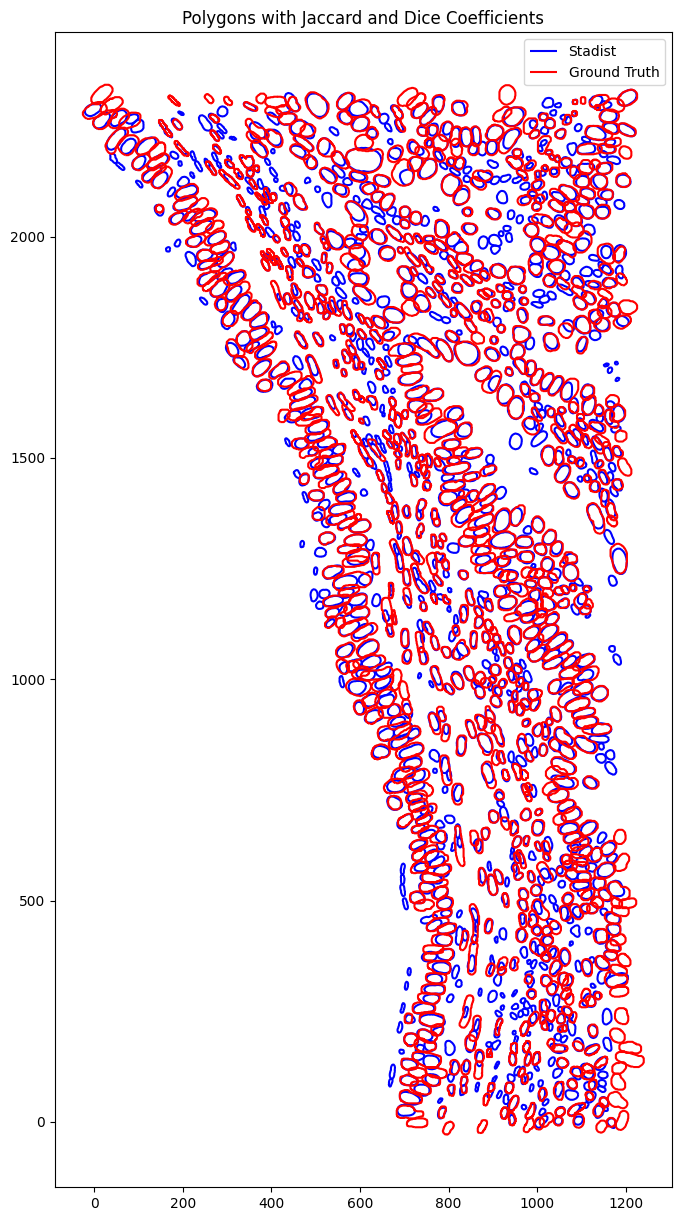

In [95]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon


# Initialize lists to store Jaccard and Dice coefficients
jaccard_indices = []
dice_coefficients = []

# Function to calculate Dice coefficient
def dice_coefficient(poly1, poly2):
    intersection_area = poly1.intersection(poly2).area
    dice_coeff = 2 * intersection_area / (poly1.area + poly2.area)
    return dice_coeff

# Iterate over each polygon in gdf1
for idx1, row1 in gdf1.iterrows():
    poly1 = row1['geometry']  # Polygon from gdf1

    # Initialize variables to store max coefficients and corresponding polygon in gdf2
    max_jaccard_index = 0
    max_jaccard_polygon = None
    max_dice_coeff = 0
    max_dice_polygon = None

    # Iterate over each polygon in gdf2 to find the maximum coefficients
    for idx2, row2 in gdf2.iterrows():
        poly2 = row2['geometry']  # Polygon from gdf2

        # Calculate Jaccard index
        intersection_area = poly1.intersection(poly2).area
        union_area = poly1.union(poly2).area
        if union_area > 0:
            jaccard_index = intersection_area / union_area
        else:
            jaccard_index = 0

        # Calculate Dice coefficient
        dice_coeff = dice_coefficient(poly1, poly2)

        # Update max Jaccard index and corresponding polygon in gdf2 if current is higher
        if jaccard_index > max_jaccard_index:
            max_jaccard_index = jaccard_index
            max_jaccard_polygon = poly2
        if dice_coeff > max_dice_coeff:
            max_dice_coeff = dice_coeff
            max_dice_polygon = poly2

    # Store the maximum coefficients found for the current polygon in gdf1
    jaccard_indices.append(max_jaccard_index)
    dice_coefficients.append(max_dice_coeff)

# Add Jaccard and Dice coefficients to gdf1 as new columns
gdf1['jaccard_index'] = jaccard_indices
gdf1['dice_coefficient'] = dice_coefficients

# Print the polygons in gdf1 with their corresponding coefficients
print(gdf1[['geometry', 'jaccard_index', 'dice_coefficient']])

# Save gdf1 with coefficients to a GeoJSON file
output_file = '../data/processed/overlap_coefficients.geojson'
gdf1.to_file(output_file, driver='GeoJSON')

# Optionally, plot the polygons in gdf1 and gdf2 with coefficients
fig, ax = plt.subplots(figsize=(10, 15))
gdf1.boundary.plot(ax=ax, color='blue', label='Stadist')
gdf2.boundary.plot(ax=ax, color='red', label='Ground Truth')
ax.set_title('Polygons with Jaccard and Dice Coefficients')
ax.legend()
plt.show()


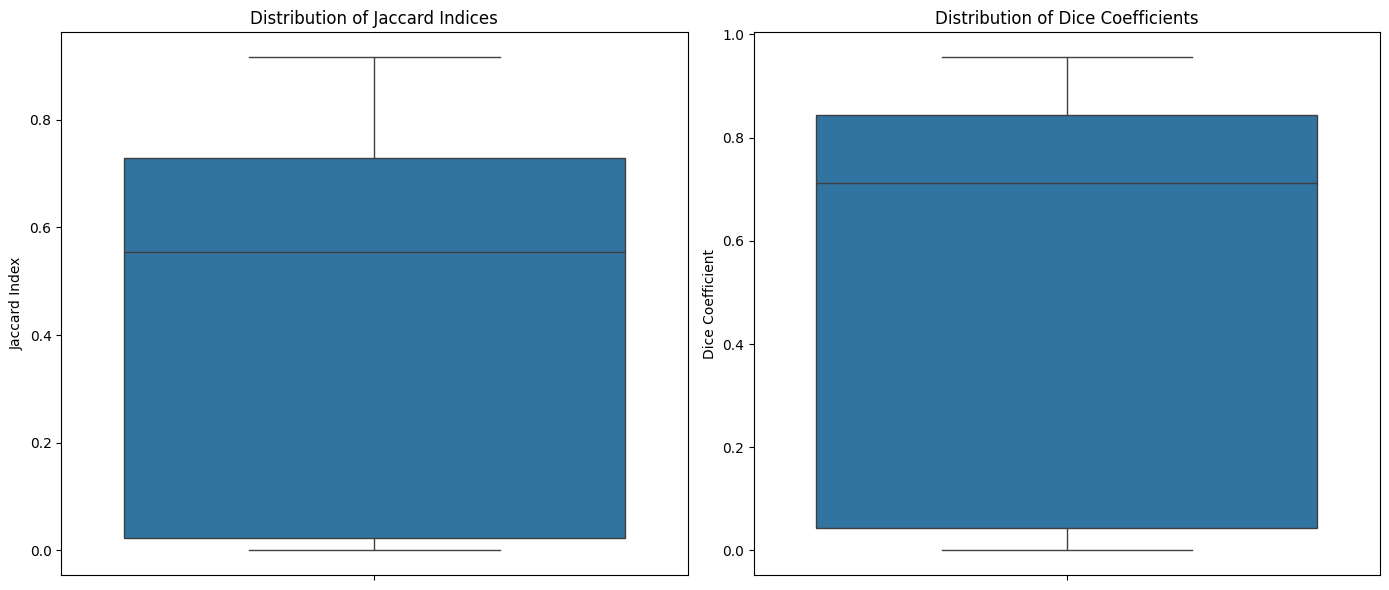

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Boxplot for Jaccard indices
sns.boxplot(data=gdf1['jaccard_index'], orient='v', ax=ax1)
ax1.set_title('Distribution of Jaccard Indices')
ax1.set_ylabel('Jaccard Index')

# Boxplot for Dice coefficients
sns.boxplot(data=gdf1['dice_coefficient'], orient='v', ax=ax2)
ax2.set_title('Distribution of Dice Coefficients')
ax2.set_ylabel('Dice Coefficient')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


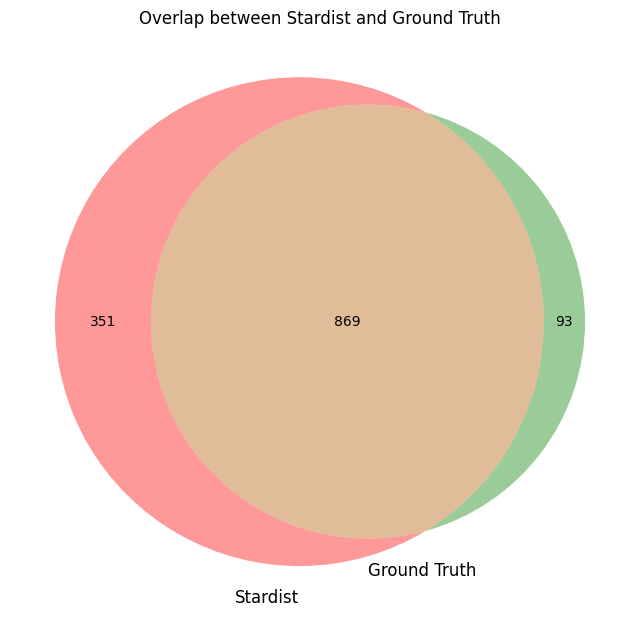

In [97]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Calculate the intersection area and the original area
overlap_gdf['intersection_area'] = overlap_gdf.apply(
    lambda row: row['geometry'].intersection(gdf2.loc[row['index_right'], 'geometry']).area, axis=1)
overlap_gdf['original_area'] = overlap_gdf['geometry'].area

# Filter for more than 50% overlap
overlap_gdf_05 = overlap_gdf[overlap_gdf['intersection_area'] / overlap_gdf['original_area'] > 0.5]

# Calculate number of unique overlaps
gdf1_non_overlap = len(gdf1) - len(overlap_gdf_05)
gdf2_non_overlap = len(gdf2) - len(overlap_gdf_05)
overlap_count = len(overlap_gdf_05)

# Plot Venn diagram
plt.figure(figsize=(8, 8))
venn2(subsets=(gdf1_non_overlap, gdf2_non_overlap, overlap_count),
      set_labels=('Stardist', 'Ground Truth'))
plt.title('Overlap between Stardist and Ground Truth')
plt.show()
